# Ecommerce fraud challenge

This notebook contians Ravelin data science challenge. Given the very small dataset size, model selection has to be taken very lightly as results are highly influenced by the random component of train/test splits.  
Data can be found in the `dataset/` folder or in the [original repo](https://github.com/unravelin/code-test-data-science).

In [42]:
import json
import re
import pandas as pd
import numpy as np

from collections import Counter
from imblearn.over_sampling import SMOTE
from feature_utils import *
import pickle
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import (
    LabelBinarizer,
    OneHotEncoder,
    Binarizer,
    RobustScaler
)
from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    StratifiedKFold,
    cross_val_predict
)
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report,
    accuracy_score,
    make_scorer,
    roc_curve,
    roc_auc_score
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from imblearn.pipeline import make_pipeline as make_pipeline_imb
import matplotlib.pyplot as plt
import seaborn as sns

In [43]:
data = pd.read_json('dataset/customers.json', lines=True)

In [44]:
data.head()

,fraudulent,customer,orders,paymentMethods,transactions
0,False,"{'customerEmail': 'josephhoward@yahoo.com', 'c...","[{'orderId': 'vjbdvd', 'orderAmount': 18, 'ord...","[{'paymentMethodId': 'wt07xm68b', 'paymentMeth...","[{'transactionId': 'a9lcj51r', 'orderId': 'vjb..."
1,True,"{'customerEmail': 'evansjeffery@yahoo.com', 'c...","[{'orderId': 'nlghpa', 'orderAmount': 45, 'ord...","[{'paymentMethodId': 'y3xp697jx', 'paymentMeth...","[{'transactionId': '5mi94sfw', 'orderId': 'nlg..."
2,False,"{'customerEmail': 'andersonwilliam@yahoo.com',...","[{'orderId': 'yk34y2', 'orderAmount': 33, 'ord...","[{'paymentMethodId': '8pneoi03z', 'paymentMeth...","[{'transactionId': 'q3lyvbza', 'orderId': 'yk3..."
3,False,"{'customerEmail': 'rubenjuarez@yahoo.com', 'cu...","[{'orderId': 'fbz9ep', 'orderAmount': 34, 'ord...","[{'paymentMethodId': 'pdxjdwui4', 'paymentMeth...","[{'transactionId': 'vx4cjc27', 'orderId': 'fbz..."
4,True,"{'customerEmail': 'uchen@malone.com', 'custome...","[{'orderId': '56h7iw', 'orderAmount': 71, 'ord...","[{'paymentMethodId': 'w1i1zq3rg', 'paymentMeth...","[{'transactionId': 'q8j3dgni', 'orderId': '56h..."


## Feature engineering

In order to avoid a huge notebook, all the methods related to feature enginnering have been placed in the `feature_utils` module.

In [45]:
df = pd.DataFrame()

y = data['fraudulent']

# Transactions features
df['n_transactions'] = data['transactions'].apply(lambda x: len(x))
df['total_amt_tx'] = data['transactions'].apply(total_amt)
df['avg_amt_tx'] = data['transactions'].apply(avg_amt)
df['n_tx_failed'] = data['transactions'].apply(n_tx_failed)

# Payment methods features
df['n_payment_methods'] = data['paymentMethods'].apply(lambda x: len(x))
df['pm_registration_fails'] = data['paymentMethods'].apply(pm_registration_fails)
df['n_payment_issuer'] = data['paymentMethods'].apply(lambda x: n_distinct(x, 'paymentMethodIssuer'))
df['n_payment_provider'] = data['paymentMethods'].apply(lambda x: n_distinct(x, 'paymentMethodProvider'))
df['n_payment_type'] = data['paymentMethods'].apply(lambda x: n_distinct(x, 'paymentMethodType'))

# Orders features
df['n_orders'] = data['orders'].apply(lambda x: len(x))
df['total_amt_ord'] = data['orders'].apply(tot_amt_ordered)
df['avg_amt_ord'] = data['orders'].apply(avg_ordered)
df['order_states'] = data['orders'].apply(order_states)
df['n_addresses'] = data['orders'].apply(lambda x: len(get_n_addresses(x)))
df['state'] = data['orders'].apply(get_addr_states)
df['zipcodes'] = data['orders'].apply(get_zipcode)
df['n_zipcodes'] = data['orders'].apply(lambda x: len(get_zipcode(x)))

# Customer features
df['email_domain'] = data['customer'].apply(get_email_domain)
df['billing_shipping_mismatch'] = data.apply(lambda x: address_mismatch(x), axis=1)
df['username_vowels_ratio'] = data['customer'].apply(vowels_ratio)

df = df.fillna(0)

/home/andodet/code/study/code-test-data-science/venv/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


## Light data exploration

In [46]:
df.shape

(168, 20)

### Order distribution

From the distributions plotted below, a few insights can be drawn:

* Most users have between 1 and 2 **payment methods** associated to their account.
* Same as above applies to the number of **addresses** associated to each account.
* Most users tend to **spend** between \\$0 and \\$50 during their lifetime.
* It is fairly rare to encounter **failed transaction**.
* Most users get goods delivered to the same **billing address**. A mismatch might signal someone is testing cards and looking to get the goods delivered to a different location.

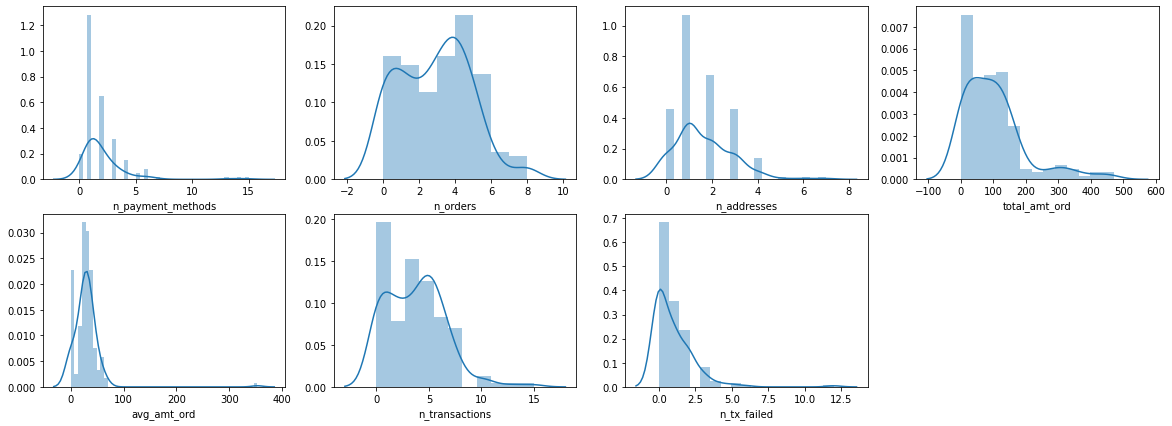

In [47]:
f, axes = plt.subplots(2, 4, figsize=(20,7), sharex=False)
axes[1,3].axis('off')  # discard unused plot space

sns.distplot(df['n_payment_methods'], ax=axes[0,0])
sns.distplot(df['n_orders'], ax=axes[0,1])
sns.distplot(df['n_addresses'], ax=axes[0,2])
sns.distplot(df['total_amt_ord'], ax=axes[0,3])
sns.distplot(df['avg_amt_ord'], ax=axes[1,0])
sns.distplot(df['n_transactions'], ax=axes[1,1])
sns.distplot(df['n_tx_failed'], ax=axes[1,2])

### Common email domains

**Email domains** distribution is in line with the most common email providers (gmail, yahoo, hotmail).

Text(0.5, 1.0, 'Most common email domains')

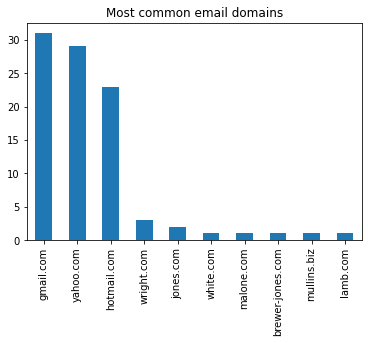

In [48]:
# Common email domains
df['email_domain'].value_counts().nlargest(10).plot.bar()
plt.title('Most common email domains')

### Common payment methods

Cards are the most common payment method.

Text(0.5, 1.0, 'Most common payment methods')

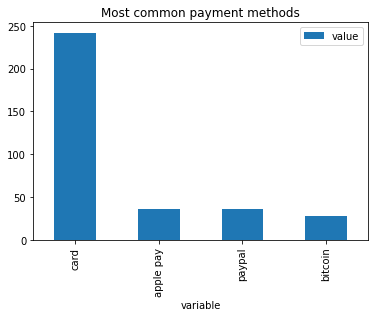

In [49]:
pm_counts = data['paymentMethods'].apply(get_payment_methods)
pm_counts = pd.DataFrame.from_dict(pm_counts)
pm_counts = pd.json_normalize(pm_counts['paymentMethods'])

# Get data to long format and plot it
pm_counts = pd.melt(pm_counts)
pm_grouped = pm_counts.groupby(['variable']).sum()
pm_grouped.sort_values(by='value', ascending=False).plot.bar()
plt.title("Most common payment methods")

In most cases (75%), users used their billing address as a delivery address at least once.

In [50]:
df['billing_shipping_mismatch'].value_counts()

False    127
True      41
Name: billing_shipping_mismatch, dtype: int64

## Model evaluation

Given the small size of the dataset, 3 models will be explored:

* Simple logistic regression
* Random forest
* Knn classifier

Hyperparaemter tuning will be skipped as it would be overkill for a dataset of this size.

In [51]:
# Helper functions

def eval_model(model, cv, x_train, y_train, x_test, y_test):
    '''Evaluates a model and prints performance metrics'''
    model.fit(x_train, y_train)
    print(f"cv score: {cross_val_score(model, x_train, y_train, cv=cv).mean()}")
    print(f"test score: {model.score(x_test, y_test)}")
    print("train classification report")
    print(classification_report(y_train, model.predict(x_train)))
    print("test classification report")
    print(y_test.shape)
    print(classification_report(y_test, model.predict(x_test)))
    
    # return fitted model
    return model

def plt_roc_auc(classifier, x_test, y_test):
    '''Plot roc-auc curve'''
    preds_proba = classifier.predict_proba(x_test)[:,1]
    fpr, tpr, _ = roc_curve(y_test, preds_proba)
    auc = roc_auc_score(y_test, preds_proba)
    
    plt.plot(fpr, tpr)
    plt.title("AUC")
    plt.show()

In [52]:
# Split train-test datasets
x_train, x_test, y_train, y_test = train_test_split(
    df, y, test_size=0.33, stratify=y, random_state=42
)
print(x_train.shape)
print(x_test.shape)

(112, 20)
(56, 20)


In [53]:
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns

column_trans = ColumnTransformer(
    [('state', DictVectorizer(sparse=False), ('state')),
     ('zipcode', DictVectorizer(sparse=False), ('zipcodes')),
     ('email_domain', OneHotEncoder(handle_unknown='ignore'), ['email_domain']),
     ('address_mismatch', Binarizer(), ['billing_shipping_mismatch']),
     ('order_states', DictVectorizer(sparse=False), ('order_states')),
     ('num', RobustScaler(), numeric_cols)],
    remainder='passthrough'
)

x_train = column_trans.fit_transform(x_train)
x_test = column_trans.transform(x_test)

In [54]:
x_train.shape

(112, 326)

## No resampling

### Logistic regression

cv score: 0.740909090909091
test score: 0.7142857142857143
train classification report
              precision    recall  f1-score   support

       False       0.95      1.00      0.97        71
        True       1.00      0.90      0.95        41

    accuracy                           0.96       112
   macro avg       0.97      0.95      0.96       112
weighted avg       0.97      0.96      0.96       112

test classification report
(56,)
              precision    recall  f1-score   support

       False       0.73      0.89      0.80        36
        True       0.67      0.40      0.50        20

    accuracy                           0.71        56
   macro avg       0.70      0.64      0.65        56
weighted avg       0.71      0.71      0.69        56



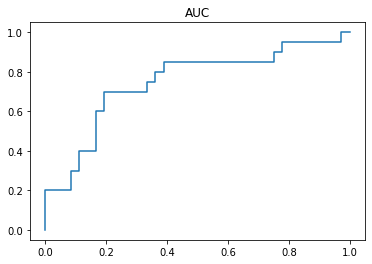

In [55]:
lr = LogisticRegression(max_iter=5000)
cv = StratifiedKFold(n_splits=10, shuffle=True)
model = eval_model(lr, cv, x_train, y_train, x_test, y_test)
plt_roc_auc(model, x_test, y_test)

### Random forest

Keeping in mind that results can be influenced on how the train/test splits are built. It seems that (at least for this run) we can identify 3 key trends to correctly classify fraud:

* Junk emails (people bashing keyboards) is deemed important to catch fraud.
* Purchase behaviour is important (avg./tot order value, avg. transaction, etc).
* Having different payment providers is fishy.


cv score: 0.7318181818181818
test score: 0.8214285714285714
train classification report
              precision    recall  f1-score   support

       False       1.00      1.00      1.00        71
        True       1.00      1.00      1.00        41

    accuracy                           1.00       112
   macro avg       1.00      1.00      1.00       112
weighted avg       1.00      1.00      1.00       112

test classification report
(56,)
              precision    recall  f1-score   support

       False       0.78      1.00      0.88        36
        True       1.00      0.50      0.67        20

    accuracy                           0.82        56
   macro avg       0.89      0.75      0.77        56
weighted avg       0.86      0.82      0.80        56



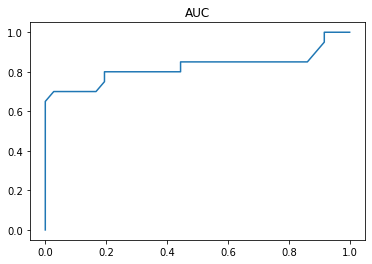

Text(0.5, 1.0, 'Feature importance')

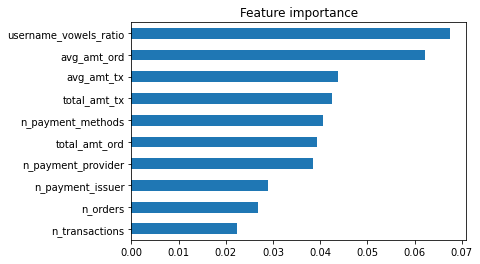

In [56]:
rf = RandomForestClassifier(random_state=42)
cv = StratifiedKFold(n_splits=10, shuffle=True)
fitted_rf = eval_model(rf, cv, x_train, y_train, x_test, y_test)
plt_roc_auc(rf, x_test, y_test)

# Plot feature importance
feat_importances = pd.Series(fitted_rf.feature_importances_,
                             index=get_ct_feature_names(column_trans))
feat_importances.nlargest(10).sort_values(ascending=True).plot(kind='barh')
plt.title("Feature importance")

### K Neighbours

cv score: 0.7265151515151516
test score: 0.7321428571428571
train classification report
              precision    recall  f1-score   support

       False       0.78      0.93      0.85        71
        True       0.81      0.54      0.65        41

    accuracy                           0.79       112
   macro avg       0.80      0.73      0.75       112
weighted avg       0.79      0.79      0.77       112

test classification report
(56,)
              precision    recall  f1-score   support

       False       0.73      0.92      0.81        36
        True       0.73      0.40      0.52        20

    accuracy                           0.73        56
   macro avg       0.73      0.66      0.67        56
weighted avg       0.73      0.73      0.71        56



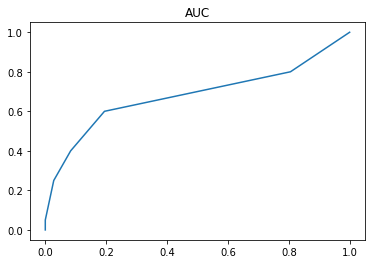

In [57]:
knn = KNeighborsClassifier()
cv = StratifiedKFold(n_splits=10, shuffle=True)
eval_model(knn, cv, x_train, y_train, x_test, y_test)
plt_roc_auc(knn, x_test, y_test)

## Using resampling

With

### Logistic regression

cv score: 0.7310606060606061
test score: 0.6964285714285714
train classification report
              precision    recall  f1-score   support

       False       0.97      0.99      0.98        71
        True       0.97      0.95      0.96        41

    accuracy                           0.97       112
   macro avg       0.97      0.97      0.97       112
weighted avg       0.97      0.97      0.97       112

test classification report
(56,)
              precision    recall  f1-score   support

       False       0.73      0.83      0.78        36
        True       0.60      0.45      0.51        20

    accuracy                           0.70        56
   macro avg       0.67      0.64      0.65        56
weighted avg       0.68      0.70      0.68        56



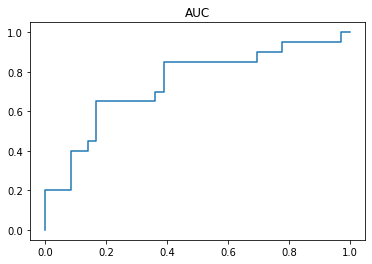

In [58]:
skfcv = StratifiedKFold(n_splits=10, shuffle=True)
lr = LogisticRegression(max_iter=5000)

pipe = make_pipeline_imb(SMOTE(sampling_strategy='all', random_state=42),
                         LogisticRegression(max_iter=5000))
pipe.fit(x_train, y_train)

eval_model(pipe, skfcv, x_train, y_train, x_test, y_test)
plt_roc_auc(pipe, x_test, y_test)

### Random forest

cv score: 0.6977272727272728
test score: 0.8571428571428571
train classification report
              precision    recall  f1-score   support

       False       1.00      1.00      1.00        71
        True       1.00      1.00      1.00        41

    accuracy                           1.00       112
   macro avg       1.00      1.00      1.00       112
weighted avg       1.00      1.00      1.00       112

test classification report
(56,)
              precision    recall  f1-score   support

       False       0.82      1.00      0.90        36
        True       1.00      0.60      0.75        20

    accuracy                           0.86        56
   macro avg       0.91      0.80      0.82        56
weighted avg       0.88      0.86      0.85        56



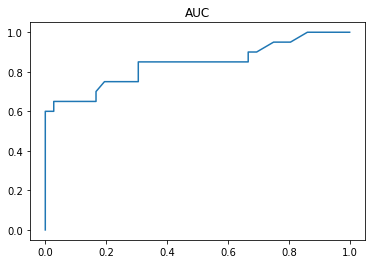

In [59]:
skfcv = StratifiedKFold(n_splits=10, shuffle=True)
rf = RandomForestClassifier(random_state=42)

pipe = make_pipeline_imb(SMOTE(sampling_strategy='all', random_state=42),
                         RandomForestClassifier(random_state=42))
pipe.fit(x_train, y_train)
eval_model(pipe, skfcv, x_train, y_train, x_test, y_test)
plt_roc_auc(pipe, x_test, y_test)

### K Neighbors

cv score: 0.5257575757575756
test score: 0.6607142857142857
train classification report
              precision    recall  f1-score   support

       False       0.85      0.66      0.75        71
        True       0.58      0.80      0.67        41

    accuracy                           0.71       112
   macro avg       0.72      0.73      0.71       112
weighted avg       0.75      0.71      0.72       112

test classification report
(56,)
              precision    recall  f1-score   support

       False       0.77      0.67      0.72        36
        True       0.52      0.65      0.58        20

    accuracy                           0.66        56
   macro avg       0.65      0.66      0.65        56
weighted avg       0.68      0.66      0.67        56



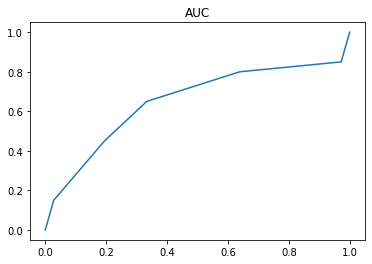

In [60]:
skfcv = StratifiedKFold(n_splits=10, shuffle=True)
knn = KNeighborsClassifier()

pipe = make_pipeline_imb(SMOTE(sampling_strategy='all', random_state=42),
                         KNeighborsClassifier())
pipe.fit(x_train, y_train)

eval_model(pipe, skfcv, x_train, y_train, x_test, y_test)
plt_roc_auc(pipe, x_test, y_test)

## Conclusions

Surprisingly, over-sampling data didn't bring any additional benefit (if anyhting, it made models' performances slightly worse). It has to be noted that dealing with such a small dataset, results are highly influenced by how the data is splitted. For this reason, this notebook should only serve a demonstrative purpose, given that no conclusions can be drawn.